In [252]:
import pandas as pd 
import numpy as np
import re
import datetime as dt
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt

import itertools


In [294]:
import warnings
warnings.filterwarnings("ignore")

In [66]:
# One entry per company
companies_df = pd.read_csv('https://raw.githubusercontent.com/notpeter/crunchbase-data/master/companies.csv')
rounds_df = pd.read_csv('https://raw.githubusercontent.com/notpeter/crunchbase-data/master/rounds.csv')

In [14]:
companies_df.shape

(66368, 14)

In [12]:
companies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66368 entries, 0 to 66367
Data columns (total 14 columns):
permalink            66368 non-null object
name                 66367 non-null object
homepage_url         61310 non-null object
category_list        63220 non-null object
funding_total_usd    66368 non-null object
status               66368 non-null object
country_code         59410 non-null object
state_code           57821 non-null object
region               58338 non-null object
city                 58340 non-null object
funding_rounds       66368 non-null int64
founded_at           51147 non-null object
first_funding_at     66344 non-null object
last_funding_at      66368 non-null object
dtypes: int64(1), object(13)
memory usage: 7.1+ MB


### Data Cleaning 

In [16]:
## Dropping rows with no name  

clean_companies = companies_df.dropna(subset=['name'])
clean_companies.shape

(66367, 14)

In [139]:
clean_companies.columns

Index(['permalink', 'name', 'category_list', 'funding_total_usd', 'status',
       'country_code', 'state_code', 'region', 'city', 'funding_rounds',
       'founded_at', 'first_funding_at', 'last_funding_at'],
      dtype='object')

In [18]:
## Drropping values with no funding date 

clean_companies = clean_companies.dropna(subset=['first_funding_at'])
clean_companies.shape

(66343, 14)

In [19]:
#Dropping homepage_url 
clean_companies.drop(axis=1, columns=['homepage_url'], inplace=True)

In [125]:
# Fill empty country with 'unknown'
clean_companies.country_code.fillna('unknown', inplace=True)

Text(0.5,1,'Total Region Wise Distribution')

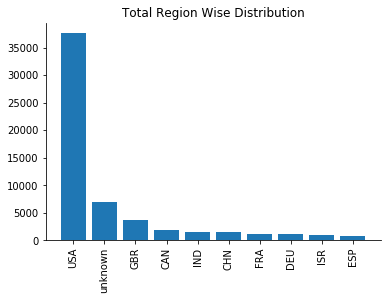

In [130]:
#Total country wise distribution 
country_dist = clean_companies.groupby(
    'country_code').size().sort_values(ascending=False)
plt.bar(country_dist[0:10].index, height=country_dist[0:10].values)
plt.xticks(rotation=90)
sns.despine()
plt.title('Total Region Wise Distribution')

In [23]:
# Removing non sensical dates
clean_companies = clean_companies[
    clean_companies.first_funding_at.str.match(r'(19)|(20)')]
clean_companies = clean_companies[
    clean_companies.last_funding_at.str.match(r'(19)|(20)')]
clean_companies.shape

(66338, 13)

In [34]:
clean_companies.first_funding_at = pd.to_datetime(
    clean_companies.loc[:, 'first_funding_at'])
clean_companies.last_funding_at = pd.to_datetime(
    clean_companies.loc[:, 'last_funding_at'])
clean_companies.shape

(66338, 13)

In [28]:
# '-' -> NaNs 
clean_companies.funding_total_usd.replace('-', np.nan, inplace=True)

In [29]:
# conversting funding_total_usd, funding_rounds  from object -> number 

clean_companies.funding_total_usd = pd.to_numeric(
    clean_companies.loc[:, 'funding_total_usd'])

clean_companies.funding_rounds = pd.to_numeric(
    clean_companies.loc[:, 'funding_rounds'])


In [30]:
clean_companies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66338 entries, 0 to 66367
Data columns (total 13 columns):
permalink            66338 non-null object
name                 66338 non-null object
category_list        63191 non-null object
funding_total_usd    53555 non-null float64
status               66338 non-null object
country_code         59383 non-null object
state_code           57794 non-null object
region               58311 non-null object
city                 58313 non-null object
funding_rounds       66338 non-null int64
founded_at           51122 non-null object
first_funding_at     66338 non-null object
last_funding_at      66338 non-null object
dtypes: float64(1), int64(1), object(11)
memory usage: 7.1+ MB


In [132]:
# Operating companies older than 2 years ago 
operating_countries = clean_companies[np.logical_and(
    np.logical_and(clean_companies.last_funding_at < pd.to_datetime('2013'),
                   clean_companies.first_funding_at > '2005'),
    clean_companies.status == 'operating')]

In [133]:
operating_countries

,permalink,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
3,/organization/0-6-com,0-6.com,Curated Web,2000000.0,operating,CHN,22,Beijing,Beijing,1,2007-01-01,2008-03-19,2008-03-19
6,/organization/0ndine-biomedical-inc,Ondine Biomedical Inc.,Biotechnology,762851.0,operating,CAN,BC,Vancouver,Vancouver,2,1997-01-01,2009-09-11,2009-12-21
12,/organization/1-800-dentist,1-800-DENTIST,Health and Wellness,NaN,operating,USA,CA,Los Angeles,Los Angeles,1,1986-01-01,2010-08-19,2010-08-19
13,/organization/1-800-doctors,1-800-DOCTORS,Health and Wellness,1750000.0,operating,USA,NJ,Newark,Iselin,1,1984-01-01,2011-03-02,2011-03-02
17,/organization/10-20-media,10-20 Media,E-Commerce,2050000.0,operating,USA,MD,Baltimore,Woodbine,4,2001-01-01,2009-06-18,2011-12-28
19,/organization/1000-corks,1000 Corks,Search,40000.0,operating,USA,OR,"Portland, Oregon",Lake Oswego,1,2008-01-01,2011-08-23,2011-08-23
21,/organization/1000chi,Beijing 1000CHI Software Technology,Mobile,43923865.0,operating,unknown,NaN,NaN,NaN,1,2008-01-01,2010-04-01,2010-04-01
28,/organization/100du-tv,100du.tv,Hospitality,3000000.0,operating,CHN,23,Shanghai,Shanghai,2,NaN,2008-01-07,2010-08-13
29,/organization/100e-com,100e.com,Education,4500000.0,operating,CHN,22,Beijing,Beijing,2,NaN,2006-01-01,2006-09-01
37,/organization/10seconds-software,10seconds Software,Enterprise Software|Mobility|Software,100000.0,operating,AUS,2,Sydney,Sydney,1,2009-07-01,2010-07-01,2010-07-01


Text(0.5,1,'Operating Companies- Region Wise Distribution')

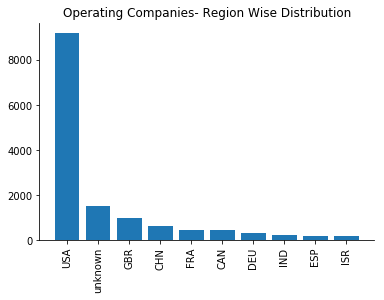

In [134]:
#Country wise distribution/ Operating Countries  
country_dist = operating_countries.groupby(
    'country_code').size().sort_values(ascending=False)
plt.bar(country_dist[0:10].index, height=country_dist[0:10].values)
plt.xticks(rotation=90)
sns.despine()
plt.title('Operating Companies- Region Wise Distribution')

In [37]:
current_date =clean_companies.last_funding_at.max()

In [38]:
current_date

Timestamp('2015-12-12 00:00:00')

In [85]:
# non operating companies 
no_companies = clean_companies[np.logical_and(
    np.logical_and(clean_companies.last_funding_at < pd.to_datetime('2013'),
                   clean_companies.first_funding_at > '2005'),
    clean_companies.status != 'operating')]

In [86]:
no_companies

,permalink,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
20,/organization/1000-markets,1000 Markets,Art|E-Commerce|Marketplaces,5.000000e+05,acquired,USA,WA,Seattle,Seattle,1,2009-01-01,2009-05-15,2009-05-15
23,/organization/1000memories,1000memories,Curated Web,2.535000e+06,acquired,USA,CA,SF Bay Area,San Francisco,2,2010-07-01,2010-01-01,2011-02-16
31,/organization/100plus,100Plus,Analytics,1.250000e+06,acquired,USA,CA,SF Bay Area,San Francisco,2,2011-09-16,2011-11-02,2011-11-30
32,/organization/1010data,1010data,Software,3.500000e+07,acquired,USA,NY,New York City,New York,1,2000-01-01,2010-03-08,2010-03-08
34,/organization/10bestthings,10BestThings,Curated Web,5.000000e+04,closed,USA,OH,Cleveland,Cleveland,1,2009-04-01,2009-04-01,2009-04-01
47,/organization/11i-solutions,11i Solutions,Enterprise Software,1.800000e+06,closed,USA,AL,Huntsville,Huntsville,1,NaN,2011-03-22,2011-03-22
58,/organization/123people,yelster digital gmbh (former 123people),Local Search|Software|Web Design,NaN,acquired,AUT,9,Vienna,Vienna,1,2007-01-01,2008-01-01,2008-01-01
64,/organization/12society,12Society,E-Commerce,NaN,acquired,USA,CA,Los Angeles,West Hollywood,1,2012-01-01,2012-04-05,2012-04-05
67,/organization/13th-lab,13th Lab,Augmented Reality|Computer Vision|Games|iPad|M...,7.000000e+05,acquired,SWE,26,Stockholm,Stockholm,1,2010-01-01,2012-06-15,2012-06-15
76,/organization/169-st,169 ST.,Entertainment|Games,5.000000e+04,closed,USA,FL,Orlando,Lake Mary,1,2009-05-15,2009-06-01,2009-06-01


In [87]:
#Closed =1, ipo, accquired = 1 
no_companies['Result'] = np.nan

no_companies.loc[no_companies.status == 'closed', 'Result'] = 0
no_companies.loc[np.logical_or(
    no_companies.status == 'ipo', no_companies.status
    == 'acquired'), 'Result'] = 1

/Users/rohitsaluja/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/rohitsaluja/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [88]:
no_companies = no_companies.reset_index()

In [98]:
no_companies = no_companies.drop('index', 1)

In [99]:
no_companies 

,permalink,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,Result,cat_list
0,/organization/1000-markets,1000 Markets,Art|E-Commerce|Marketplaces,5.000000e+05,acquired,USA,WA,Seattle,Seattle,1,2009-01-01,2009-05-15,2009-05-15,1.0,"[Art, E-Commerce, Marketplaces]"
1,/organization/1000memories,1000memories,Curated Web,2.535000e+06,acquired,USA,CA,SF Bay Area,San Francisco,2,2010-07-01,2010-01-01,2011-02-16,1.0,[Curated Web]
2,/organization/100plus,100Plus,Analytics,1.250000e+06,acquired,USA,CA,SF Bay Area,San Francisco,2,2011-09-16,2011-11-02,2011-11-30,1.0,[Analytics]
3,/organization/1010data,1010data,Software,3.500000e+07,acquired,USA,NY,New York City,New York,1,2000-01-01,2010-03-08,2010-03-08,1.0,[Software]
4,/organization/10bestthings,10BestThings,Curated Web,5.000000e+04,closed,USA,OH,Cleveland,Cleveland,1,2009-04-01,2009-04-01,2009-04-01,0.0,[Curated Web]
5,/organization/11i-solutions,11i Solutions,Enterprise Software,1.800000e+06,closed,USA,AL,Huntsville,Huntsville,1,NaN,2011-03-22,2011-03-22,0.0,[Enterprise Software]
6,/organization/123people,yelster digital gmbh (former 123people),Local Search|Software|Web Design,NaN,acquired,AUT,9,Vienna,Vienna,1,2007-01-01,2008-01-01,2008-01-01,1.0,"[Local Search, Software, Web Design]"
7,/organization/12society,12Society,E-Commerce,NaN,acquired,USA,CA,Los Angeles,West Hollywood,1,2012-01-01,2012-04-05,2012-04-05,1.0,[E-Commerce]
8,/organization/13th-lab,13th Lab,Augmented Reality|Computer Vision|Games|iPad|M...,7.000000e+05,acquired,SWE,26,Stockholm,Stockholm,1,2010-01-01,2012-06-15,2012-06-15,1.0,"[Augmented Reality, Computer Vision, Games, iP..."
9,/organization/169-st,169 ST.,Entertainment|Games,5.000000e+04,closed,USA,FL,Orlando,Lake Mary,1,2009-05-15,2009-06-01,2009-06-01,0.0,"[Entertainment, Games]"


In [100]:
no_companies.Result.value_counts()

1.0    3678
0.0    3516
Name: Result, dtype: int64

In [101]:
# no funding info 
no_companies.funding_total_usd.isna().sum()

1161

### Rounds 

In [102]:
rounds_df.head()

,company_permalink,company_name,company_category_list,company_country_code,company_state_code,company_region,company_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/-fame,#fame,Media,IND,16,Mumbai,Mumbai,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,2015-01-05,10000000.0
1,/organization/-qounter,:Qounter,Application Platforms|Real Time|Social Network...,USA,DE,DE - Other,Delaware City,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,2014-10-14,NaN
2,/organization/-qounter,:Qounter,Application Platforms|Real Time|Social Network...,USA,DE,DE - Other,Delaware City,/funding-round/b44fbb94153f6cdef13083530bb48030,seed,NaN,2014-03-01,700000.0
3,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",Apps|Games|Mobile,NaN,NaN,NaN,NaN,/funding-round/650b8f704416801069bb178a1418776b,venture,B,2014-01-30,3406878.0
4,/organization/0-6-com,0-6.com,Curated Web,CHN,22,Beijing,Beijing,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,2008-03-19,2000000.0


In [103]:
### Category of companies that got shut down 

# Fill empty category with 'unknown'
no_companies .category_list.fillna('unknown', inplace=True)

In [104]:
# Create column with list of categories
no_companies[
    'cat_list'] = no_companies.category_list.apply(str.split,
                                                                sep='|')

In [105]:
no_companies.head()

,permalink,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,Result,cat_list
0,/organization/1000-markets,1000 Markets,Art|E-Commerce|Marketplaces,500000.0,acquired,USA,WA,Seattle,Seattle,1,2009-01-01,2009-05-15,2009-05-15,1.0,"[Art, E-Commerce, Marketplaces]"
1,/organization/1000memories,1000memories,Curated Web,2535000.0,acquired,USA,CA,SF Bay Area,San Francisco,2,2010-07-01,2010-01-01,2011-02-16,1.0,[Curated Web]
2,/organization/100plus,100Plus,Analytics,1250000.0,acquired,USA,CA,SF Bay Area,San Francisco,2,2011-09-16,2011-11-02,2011-11-30,1.0,[Analytics]
3,/organization/1010data,1010data,Software,35000000.0,acquired,USA,NY,New York City,New York,1,2000-01-01,2010-03-08,2010-03-08,1.0,[Software]
4,/organization/10bestthings,10BestThings,Curated Web,50000.0,closed,USA,OH,Cleveland,Cleveland,1,2009-04-01,2009-04-01,2009-04-01,0.0,[Curated Web]


In [107]:
failed_companies = no_companies.loc[no_companies['Result'] == 0.0]

### Failed Feature Categories 

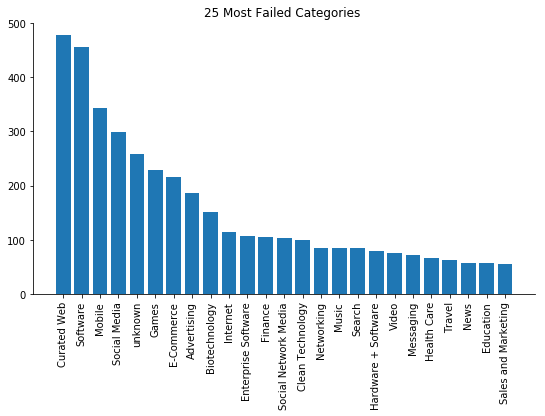

In [120]:
# Create list of category lists
categories = list(failed_companies.cat_list)
# Flatten the list
flat_categories = [cat for sublist in categories for cat in sublist]
# Count occurences of each
category_counts = Counter(flat_categories).most_common()
# Look at the distribution
plt.figure(figsize=(9, 5))
plt.bar([x[0] for x in category_counts[0:25]],
        [x[1] for x in category_counts[0:25]],
        width=0.8)
plt.xticks(rotation=90)
plt.title('25 Most Failed Categories ')
sns.despine()

### Successful Feature Categories 


In [116]:
successful_companies = no_companies.loc[no_companies['Result'] == 1.0]

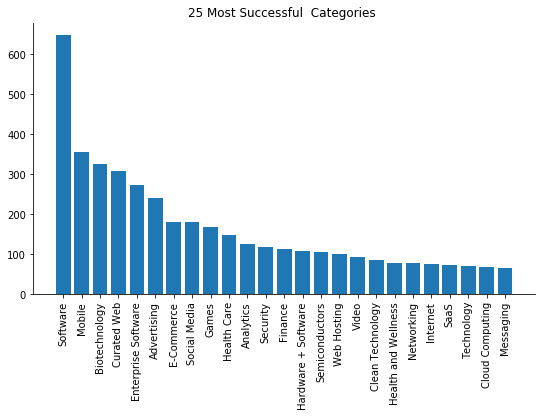

In [121]:
# Create list of category lists
categories = list(successful_companies.cat_list)
# Flatten the list
flat_categories = [cat for sublist in categories for cat in sublist]
# Count occurences of each
category_counts = Counter(flat_categories).most_common()
# Look at the distribution
plt.figure(figsize=(9, 5))
plt.bar([x[0] for x in category_counts[0:25]],
        [x[1] for x in category_counts[0:25]],
        width=0.8)
plt.xticks(rotation=90)
plt.title('25 Most Successful  Categories ')
sns.despine()

### Top Startup Locations 


In [123]:
# Fill empty country with 'unknown'
no_companies.country_code.fillna('unknown', inplace=True)

Text(0.5,1,'Succeeded/Failed Companies - Region Wise Distribution')

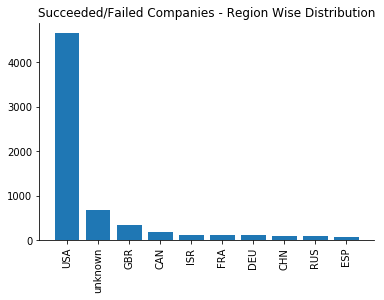

In [131]:
#Country wise distribution/ no operating companies 
country_dist = no_companies.groupby(
    'country_code').size().sort_values(ascending=False)
plt.bar(country_dist[0:10].index, height=country_dist[0:10].values)
plt.xticks(rotation=90)
sns.despine()
plt.title('Succeeded/Failed Companies - Region Wise Distribution')

### Predictive Modelling

In [136]:
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import precision_score, recall_score,\
precision_recall_curve,f1_score, fbeta_score,\
accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn import svm
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from sklearn.externals.six import StringIO
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import pydotplus
from sklearn.tree import export_graphviz
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Oswald']
font = {'size'   : 12}
plt.rc('font', **font)


In [146]:
rounds_df.head()

,company_permalink,company_name,company_category_list,company_country_code,company_state_code,company_region,company_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,raised_amount_usd
0,/organization/-fame,#fame,Media,IND,16,Mumbai,Mumbai,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,2015-01-05,10000000.0
1,/organization/-qounter,:Qounter,Application Platforms|Real Time|Social Network...,USA,DE,DE - Other,Delaware City,/funding-round/22dacff496eb7acb2b901dec1dfe5633,venture,A,2014-10-14,NaN
2,/organization/-qounter,:Qounter,Application Platforms|Real Time|Social Network...,USA,DE,DE - Other,Delaware City,/funding-round/b44fbb94153f6cdef13083530bb48030,seed,NaN,2014-03-01,700000.0
3,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",Apps|Games|Mobile,NaN,NaN,NaN,NaN,/funding-round/650b8f704416801069bb178a1418776b,venture,B,2014-01-30,3406878.0
4,/organization/0-6-com,0-6.com,Curated Web,CHN,22,Beijing,Beijing,/funding-round/5727accaeaa57461bd22a9bdd945382d,venture,A,2008-03-19,2000000.0


In [156]:
no_companies['time_bw_first_rounds'] = dt.timedelta(0)

In [157]:
no_companies['time_bw_first_rounds'] = no_companies['last_funding_at'].sub(no_companies['first_funding_at'], axis=0)

In [159]:
no_companies.columns

Index(['permalink', 'name', 'category_list', 'funding_total_usd', 'status',
       'country_code', 'state_code', 'region', 'city', 'funding_rounds',
       'founded_at', 'first_funding_at', 'last_funding_at', 'Result',
       'cat_list', 'time_bw_first_rounds'],
      dtype='object')

In [165]:
type(no_companies)

pandas.core.frame.DataFrame

In [170]:
no_companies['cat_list'] = no_companies['cat_list'].apply(tuple)

In [176]:
no_companies['country'] = no_companies['country'].apply(tuple)
no_companies['state'] = no_companies['state'].apply(tuple)

KeyError: 'country'

In [215]:
no_companies

,permalink,name,category_list,funding_total_usd,status,country_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at,Result,cat_list,time_bw_first_rounds
0,/organization/1000-markets,1000 Markets,Art|E-Commerce|Marketplaces,5.000000e+05,acquired,USA,Seattle,1,2009-01-01,2009-05-15,2009-05-15,1.0,"(Art, E-Commerce, Marketplaces)",0
1,/organization/1000memories,1000memories,Curated Web,2.535000e+06,acquired,USA,San Francisco,2,2010-07-01,2010-01-01,2011-02-16,1.0,"(Curated Web,)",411
2,/organization/100plus,100Plus,Analytics,1.250000e+06,acquired,USA,San Francisco,2,2011-09-16,2011-11-02,2011-11-30,1.0,"(Analytics,)",28
3,/organization/1010data,1010data,Software,3.500000e+07,acquired,USA,New York,1,2000-01-01,2010-03-08,2010-03-08,1.0,"(Software,)",0
4,/organization/10bestthings,10BestThings,Curated Web,5.000000e+04,closed,USA,Cleveland,1,2009-04-01,2009-04-01,2009-04-01,0.0,"(Curated Web,)",0
5,/organization/11i-solutions,11i Solutions,Enterprise Software,1.800000e+06,closed,USA,Huntsville,1,NaN,2011-03-22,2011-03-22,0.0,"(Enterprise Software,)",0
6,/organization/123people,yelster digital gmbh (former 123people),Local Search|Software|Web Design,NaN,acquired,AUT,Vienna,1,2007-01-01,2008-01-01,2008-01-01,1.0,"(Local Search, Software, Web Design)",0
7,/organization/12society,12Society,E-Commerce,NaN,acquired,USA,West Hollywood,1,2012-01-01,2012-04-05,2012-04-05,1.0,"(E-Commerce,)",0
8,/organization/13th-lab,13th Lab,Augmented Reality|Computer Vision|Games|iPad|M...,7.000000e+05,acquired,SWE,Stockholm,1,2010-01-01,2012-06-15,2012-06-15,1.0,"(Augmented Reality, Computer Vision, Games, iP...",0
9,/organization/169-st,169 ST.,Entertainment|Games,5.000000e+04,closed,USA,Lake Mary,1,2009-05-15,2009-06-01,2009-06-01,0.0,"(Entertainment, Games)",0


In [231]:
no_companies = no_companies.dropna()

In [232]:
no_companies.shape

(4318, 14)

In [234]:
no_companies

,permalink,name,category_list,funding_total_usd,status,country_code,city,funding_rounds,founded_at,first_funding_at,last_funding_at,Result,cat_list,time_bw_first_rounds
0,/organization/1000-markets,1000 Markets,Art|E-Commerce|Marketplaces,5.000000e+05,acquired,USA,Seattle,1,2009-01-01,2009-05-15,2009-05-15,1.0,"(Art, E-Commerce, Marketplaces)",0
1,/organization/1000memories,1000memories,Curated Web,2.535000e+06,acquired,USA,San Francisco,2,2010-07-01,2010-01-01,2011-02-16,1.0,"(Curated Web,)",411
2,/organization/100plus,100Plus,Analytics,1.250000e+06,acquired,USA,San Francisco,2,2011-09-16,2011-11-02,2011-11-30,1.0,"(Analytics,)",28
3,/organization/1010data,1010data,Software,3.500000e+07,acquired,USA,New York,1,2000-01-01,2010-03-08,2010-03-08,1.0,"(Software,)",0
4,/organization/10bestthings,10BestThings,Curated Web,5.000000e+04,closed,USA,Cleveland,1,2009-04-01,2009-04-01,2009-04-01,0.0,"(Curated Web,)",0
8,/organization/13th-lab,13th Lab,Augmented Reality|Computer Vision|Games|iPad|M...,7.000000e+05,acquired,SWE,Stockholm,1,2010-01-01,2012-06-15,2012-06-15,1.0,"(Augmented Reality, Computer Vision, Games, iP...",0
9,/organization/169-st,169 ST.,Entertainment|Games,5.000000e+04,closed,USA,Lake Mary,1,2009-05-15,2009-06-01,2009-06-01,0.0,"(Entertainment, Games)",0
11,/organization/1bog,One Block Off the Grid (1BOG),Clean Technology|Residential Solar,5.000000e+06,closed,USA,San Francisco,1,2008-11-01,2010-02-11,2010-02-11,0.0,"(Clean Technology, Residential Solar)",0
12,/organization/1c-company,1C Company,Games|Software|Video Games,2.000000e+08,closed,RUS,Moscow,1,1991-01-01,2011-10-03,2011-10-03,0.0,"(Games, Software, Video Games)",0
14,/organization/1daylater,1DayLater,Curated Web|Tracking,4.381100e+04,closed,AUS,Newcastle,2,2009-08-26,2009-05-01,2009-10-01,0.0,"(Curated Web, Tracking)",153


In [233]:
no_companies['time_bw_first_rounds'] = no_companies['time_bw_first_rounds'].dt.days.astype('int16')


AttributeError: Can only use .dt accessor with datetimelike values

In [178]:
no_companies = no_companies.drop('state_code', 1)
no_companies = no_companies.drop('region', 1)

In [185]:
# Category Dummies
cat_dummies = pd.get_dummies(no_companies['cat_list'], drop_first=True)
# Country Dummies
country_dummies = pd.get_dummies(no_companies['country_code'], drop_first=True)
# State Dummies
state_dummies = pd.get_dummies(no_companies['city'], drop_first=True)

In [235]:
X_col_nodummies = no_companies[[
    'funding_total_usd', 'funding_rounds', 'time_bw_first_rounds',
    ]]

In [236]:
# Merging dummies into feature matrix 
X = X_col_nodummies.merge(cat_dummies, left_index=True, right_index=True).merge(
    country_dummies, left_index=True, right_index=True).merge(state_dummies,
                                                              left_index=True,
                                                              right_index=True)

In [237]:
X.isnull().sum()

funding_total_usd                                                                                                                  0
funding_rounds                                                                                                                     0
time_bw_first_rounds                                                                                                               0
(3D, Architecture, Design, Product Design, Software)                                                                               0
(3D, Audio, Messaging, Public Relations, Real Time, Telephony, Virtualization)                                                     0
(3D, Broadcasting, Video Streaming)                                                                                                0
(3D, CAD, Hardware + Software)                                                                                                     0
(3D, Chat, CRM, Entertainment, Services, Software, Virtual Workforces

In [238]:
X.shape

(4318, 4486)

In [239]:
y = no_companies.Result

In [240]:
y.shape

(4318,)

In [241]:
# Count target values
target_count = y.value_counts()
print(target_count)

1.0    2469
0.0    1849
Name: Result, dtype: int64


The dataset is balanced 

In [242]:
# Split the data with 80% to train and 20% to test
# Stratify to ensure train and test sets have 
# similar proportions of either target class
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=40,
                                                    stratify=y)

In [243]:
# Standardize the data

scaler = StandardScaler()

# Fit the scaler using the training data and scale it
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train.values),
                              columns=X.columns)

# Scale the test data
X_test_scaled = pd.DataFrame(scaler.transform(X_test.values),
                             columns=X.columns)

### Logistic Regression

In [244]:
# Instantiate model
lr = LogisticRegression()

# Fit model to the training data
lr.fit(X_train_scaled, y_train)

/Users/rohitsaluja/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [245]:
predictions_lr = lr.predict(X_test)

In [278]:
score = lr.score(X_test, y_test)
print(score)

0.5717592592592593


In [248]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [249]:
cnf_matrix = confusion_matrix(y_test, predictions_lr)

In [250]:
cnf_matrix

array([[  0, 370],
       [  0, 494]])

### Decision Trees 

In [259]:
dt = DecisionTreeClassifier(max_depth=5)
dt.fit(X_train, y_train)



# Calculate ROC Score and AUC for decision tree
fpr_dt, tpr_dt, thresholds_dt = roc_curve(
    y_test,
    dt.predict_proba(X_test)[:, 1])  # not scaled data for dt
auc_dt = roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])

In [264]:
# Feature importance

pd.DataFrame({
    'feature': X.columns,
    'importance': dt.feature_importances_
}).sort_values(by='importance', ascending=False)[0:15]

,feature,importance
0,funding_total_usd,0.866564
3207,RUS,0.038267
2,time_bw_first_rounds,0.013506
3974,Mountain View,0.011748
3220,USA,0.009899
1041,"(Clean Technology, Solar)",0.009582
4238,Seattle,0.009126
1836,"(E-Commerce,)",0.007681
4384,Vancouver,0.007566
3158,CAN,0.007527


In [291]:
# Calculate ROC Score and AUC for decision tree
fpr_dt, tpr_dt, thresholds_dt = roc_curve(
    y_test,
    dt.predict_proba(X_test)[:, 1])  # not scaled data for dt
auc_dt = roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1])

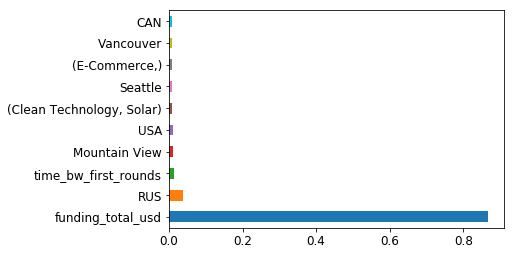

In [297]:
#plot graph of feature importances for better visualization
feat_impo_DT = pd.Series(dt.feature_importances_, index=X.columns)
feat_impo_DT.nlargest(10).plot(kind='barh')
plt.show()

In [265]:
predictions_dt = dt.predict(X_test)

In [267]:
score_dt = dt.score(X_test, y_test)


In [268]:
score_dt

0.7152777777777778

### SVM 

In [270]:
svm = svm.SVC(kernel="linear", probability=True)
svm.fit(X_train_scaled, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [274]:
predictions_svm = svm.predict(X_test)

In [275]:
score_svm = svm.score(X_test, y_test)

In [279]:
svm.score(X_test,y_test)

0.5717592592592593

In [277]:
score_svm

0.5717592592592593

In [289]:
# Calculate ROC Score and AUC for SVM
fpr_svm_model, tpr_svm_model, thresholds_svm_model = roc_curve(
    y_test,
    svm.predict_proba(X_test_scaled)[:, 1])  # scaled for SVM
auc_svm_model = roc_auc_score(
    y_test,
    svm.predict_proba(X_test_scaled)[:, 1])  # scaled for SVM

### Random Forests

In [281]:
# Instantiate Model
rf = RandomForestClassifier(n_estimators=500,
                            bootstrap=True,
                            oob_score=True,
                            random_state=1234,
                            n_jobs=-1)

# fit
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=True, random_state=1234, verbose=0, warm_start=False)

In [282]:
score_rf = rf.score(X_test, y_test)

In [283]:
score_rf

0.7175925925925926

In [290]:
# Calculate ROC Score and AUC for random forest
fpr_rf, tpr_rf, thresholds_rf = roc_curve(
    y_test,
    rf.predict_proba(X_test)[:, 1])  # not scaled for rf
auc_rf = roc_auc_score(y_test,
                       rf.predict_proba(X_test)[:, 1])  # not scaled for rf

### Feature Importance RF 

In [284]:
# Feature importance

rf_feats = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=False)

# Look at top 10 features
rf_feats[0:10]

,feature,importance
0,funding_total_usd,0.218436
2,time_bw_first_rounds,0.066467
1,funding_rounds,0.035299
3091,"(Software,)",0.009341
3220,USA,0.008716
1444,"(Curated Web,)",0.007412
4203,San Francisco,0.007165
2806,"(Mobile,)",0.006482
765,"(Biotechnology,)",0.005516
3207,RUS,0.005502


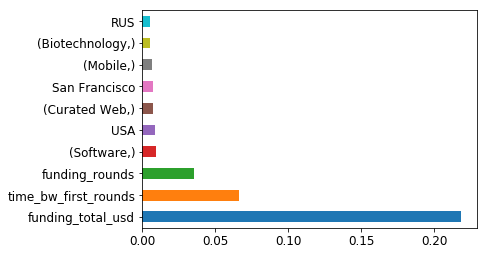

In [296]:
#plot graph of feature importances for better visualization
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

### Model Perfomance Comparison

In [292]:
models = ['dt','svm','rf']
model_aucs = [
    auc_dt,auc_svm_model,auc_rf
]

model_names = [
    'Decision Tree', 'Support Vector Machine', 'Random Forest'
]

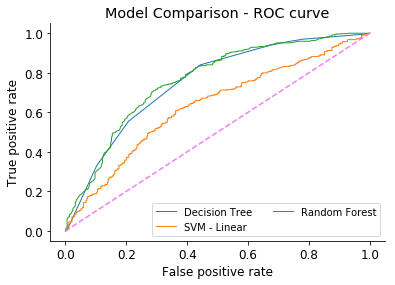

In [295]:
plt.plot(fpr_dt, tpr_dt, lw=1, label='Decision Tree')
plt.plot(fpr_svm_model, tpr_svm_model, lw=1, label='SVM - Linear')
plt.plot(fpr_rf, tpr_rf, lw=1, label='Random Forest')

plt.plot([0, 1], [0, 1], c='violet', ls='--')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Model Comparison - ROC curve')
plt.legend(ncol=2, fontsize='small')
sns.despine()

In [303]:
lr_reg = LogisticRegression(solver='saga',
                            C=0.1,
                            penalty='elasticnet',
                            l1_ratio=0.95)
lr_reg.fit(X_train_scaled, y_train)


ValueError: Logistic Regression supports only penalties in ['l1', 'l2'], got elasticnet.